In [32]:
import configparser
import json
import os
import pickle

import bz2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.cluster
import sklearn.manifold
import scipy.special

import utils

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
config = configparser.ConfigParser()
config.read('../config.ini')
g = config['general']

In [26]:
users = pd.read_csv(
    os.path.join(g['save_path'], 'science/users/user_label_counts_2007-2010.csv'),
    # compression='gzip'
)
users.head()

,author,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,---sniff---,0,4,0,0,3,0,0,0,0,0,0,0,1,0,0
1,-Borfo-,0,2,0,0,2,0,6,0,6,1,0,0,0,1,3
2,-GuybrushThreepwood-,0,3,0,0,0,2,2,1,0,0,0,0,1,0,0
3,-J-,0,0,1,0,1,1,4,0,0,5,2,2,1,0,0
4,-Mu-,1,0,0,0,4,0,0,1,0,5,1,4,9,0,0


In [27]:
users.shape

(15027, 16)

In [38]:
X = users.drop(['author'], axis=1).values
X = scipy.special.softmax(X, axis=1)

cm = sklearn.cluster.KMeans(
    n_clusters=40,
)
cm.fit(X)
np.unique(cm.labels_, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39], dtype=int32),
 array([1630,  426,  600,   52,  219,  261,  315,  213,  308,  235,  375,
         314,  210,  145,  232,  359,  379,  458,  270,  256,  340,  644,
         228,  375,  198,  234,  627,  326,  304,  983,  402,  241,  699,
         395,  320,  272,  592,  181,  304,  105]))

In [43]:
tsne = sklearn.manifold.TSNE(
    n_components=2,
    perplexity=35,
    random_state=314,
)
Xt = tsne.fit_transform(X)
Xt.shape

(15027, 2)

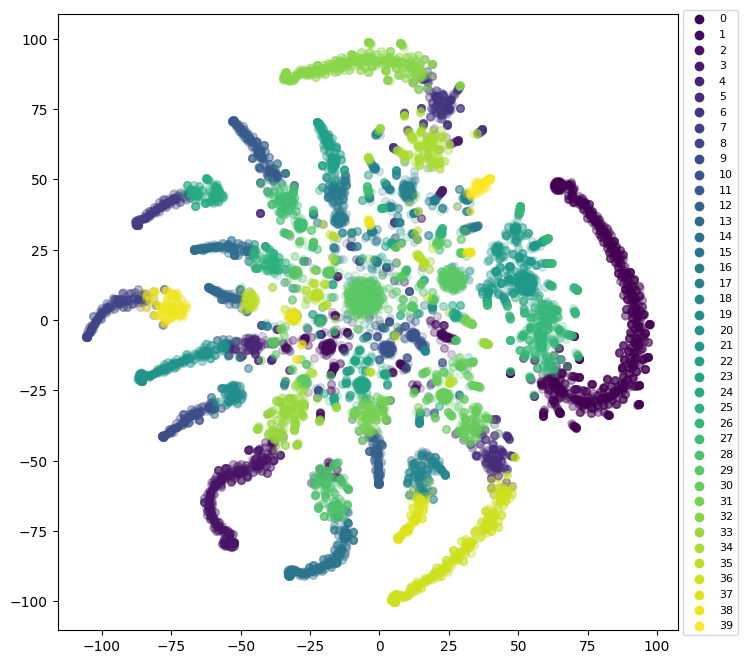

In [49]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

colors = plt.cm.viridis(np.linspace(0, 1, len(np.unique(cm.labels_))))
for cluster_label, color in zip(np.unique(cm.labels_), colors):
    if cluster_label == -1:
        continue
    cluster_points = Xt[cm.labels_ == cluster_label]
    ax.scatter(
        cluster_points[:, 0], cluster_points[:, 1], 
        s=30, color=color, alpha=0.2)
    ax.scatter([], [], color=color, label=f'{cluster_label}')

# gix = np.where(cm.labels_ == -1)[0]
# ax.scatter(Xt[gix,0], Xt[gix,1], s=30, color='k', alpha=0.05)
ax.legend(loc='center left', fontsize=8, bbox_to_anchor=(1, 0.5))
plt.show()

In [57]:
uix = np.where(cm.labels_==22)[0]
users.loc[uix[:5],:]

,author,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
4,-Mu-,1,0,0,0,4,0,0,1,0,5,1,4,9,0,0
106,7805,0,2,0,0,4,15,1,1,1,1,3,1,19,0,12
193,AggroBoy,0,0,0,0,0,2,2,0,0,0,0,0,4,0,0
231,Allakhellboy,1,0,0,1,0,1,2,0,0,1,1,0,4,0,0
379,AtomicAmish,1,4,0,0,0,2,3,0,0,2,3,2,6,1,0


In [51]:
with open(os.path.join(g['save_path'], 'science/tfidf/tfidf_2007-2010.pkl'), 'rb') as f:
    tfidf = pickle.load(f)

In [59]:
tfidf['tfidf'][12]['keywords']

array(['bradley', 'reuters', 'blogspam', 'submitter', 'ai2', 'newsweek',
       'climateaudit', 'fbi', 'truthers', 'poe', 'crock', 'oprr',
       'debunk', 'explosives', 'editors', 'siphon', 'ai1', 'wsj', 'nyt',
       'outlets'], dtype=object)

# older

In [21]:
with open(os.path.join(g['save_path'], 'sr/movies/tfidf/tfidf_2010-2.pkl'), 'rb') as f:
    tfidf = pickle.load(f)

In [22]:
tfidf['tfidf'][8]['keywords']

array(['loved', 'pacing', 'terrible', 'sort', 'cinema', 'scenes',
       'intense', 'superb', 'friends', 'needed', 'direction', 'myself',
       'power', 'done', 'found', 'disappointed', 'audience', 'theater',
       'terrifying', 'sat'], dtype=object)

In [23]:
metadata = pd.read_csv(
    os.path.join(g['meta_path'], f'metadata_2010-01.csv'),
    compression='gzip'
)
metadata.head()

,id,name,created_utc,parent_id,subreddit,subreddit_id,author,idx
0,c0i12v3,t1_c0i12v3,1262304000,t3_akcbt,politics,t5_2cneq,David_ungerer,0
1,c0i12v4,t1_c0i12v4,1262304001,t1_c0i12q0,offbeat,t5_2qh11,JayDurst,1
2,c0i12v5,t1_c0i12v5,1262304001,t3_akcaj,gaming,t5_2qh03,uninhibited,2
3,c0i12v7,t1_c0i12v7,1262304002,t3_akddz,gonewild,t5_2qq5c,parl,3
4,c0i12v8,t1_c0i12v8,1262304004,t1_c0i12gs,IAmA,t5_2qzb6,epsilondelta,4


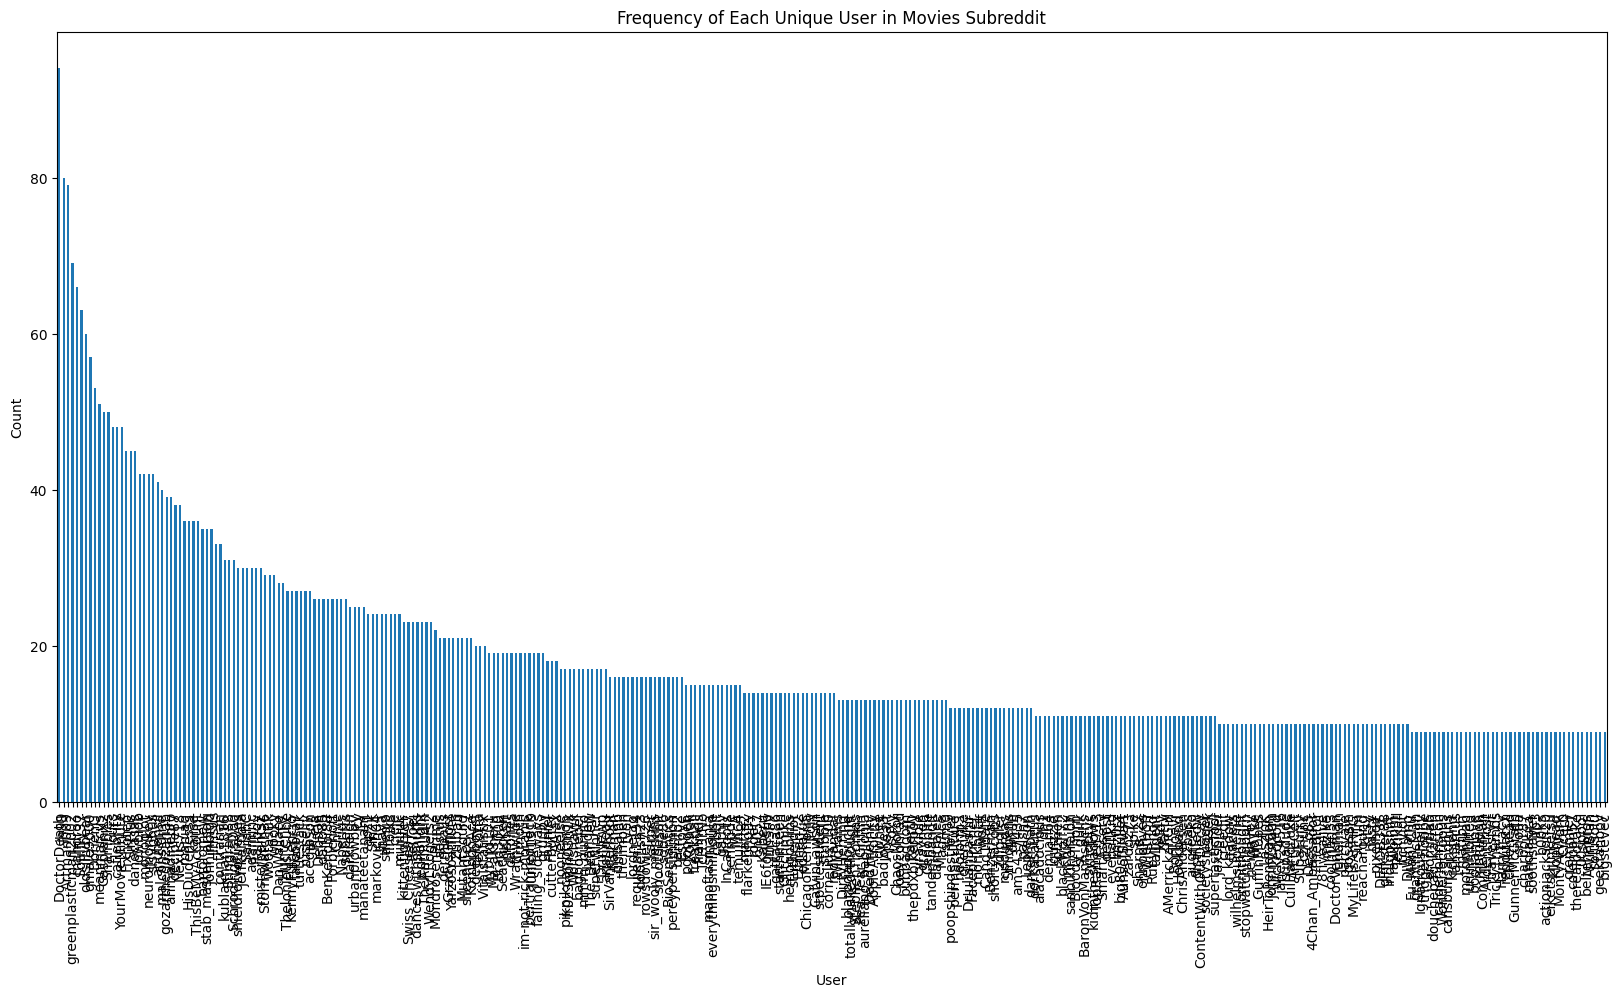

In [27]:
# Filter the dataframe for rows where subreddit is "movies"
movies_df = metadata[metadata['subreddit'] == 'movies']

# Get the frequency counts of each unique user
user_counts = movies_df['author'].value_counts()

# Keep only the top users based on counts
top_users = user_counts[user_counts >= user_counts.quantile(0.90)]

top_users.plot(kind='bar', figsize=(20, 10))
plt.xlabel('User')
plt.ylabel('Count')
plt.title('Frequency of Each Unique User in Movies Subreddit')
plt.show()

In [31]:
type(top_users)

pandas.core.series.Series

In [30]:
top_users

author
DoctorDeath            94
jh99                   80
Artman009              79
greenplasticman2002    69
mahdroo                66
                       ..
beltenebros             9
AlvinBlah               9
solusolu                9
geekfanboy              9
bigstevec               9
Name: count, Length: 346, dtype: int64

In [29]:
embeddings = utils.load_embeddings(2010, 1, embed_path=g['embed_path'])
embeddings = embeddings[movies_df['idx']]
embeddings.shape

(13303, 384)

In [16]:
soi = 'movies'

metadata = ['id', 'name', 'created_utc', 'parent_id', 
            'subreddit', 'subreddit_id', 'author']

reader = utils.read_file(
    os.path.join(DATA_PATH, 'RC_2010-01.bz2'), 
    return_type='metadata',
    metadata=metadata, 
    chunk_size=10000
)

res = []

# k will keep track of line and should align with embeddings
k = 0
for chunk in reader:
    for entry in chunk:
        if entry['subreddit'] == soi:
            entry['idx'] = k
            res.append(entry)
        k += 1

In [17]:
df_res = pd.DataFrame(res)
df_res.head()

,id,name,created_utc,parent_id,subreddit,subreddit_id,author,idx
0,c0i12y9,t1_c0i12y9,1262304136,t3_akd1b,movies,t5_2qh3s,bbittner,69
1,c0i12yf,t1_c0i12yf,1262304145,t1_c0i0xg6,movies,t5_2qh3s,passingby,75
2,c0i136p,t1_c0i136p,1262304464,t3_akc13,movies,t5_2qh3s,andhelostthem,293
3,c0i13at,t1_c0i13at,1262304618,t1_c0i0y0u,movies,t5_2qh3s,Wrathwilde,411
4,c0i13mq,t1_c0i13mq,1262305018,t3_akd1b,movies,t5_2qh3s,rawbinm,752


In [23]:
embeddings = utils.load_embeddings(2010, 1)

# grab just within subreddit
idx = df_res['idx'].values
embeddings = embeddings[idx]

In [24]:
embeddings.shape

(13303, 384)